In [2]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    print('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [3]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlCtx.createDataFrame(pandas_df, p_schema)

In [87]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 5000
random_state = 42
n_clusters = 7
X, y = make_blobs(n_samples=n_samples, centers=n_clusters)

df = pd.DataFrame(X, columns=['A', 'B'])
df_spark = pandas_to_spark(df)

n_clusters

df = pd.DataFrame(X, columns=['A', 'B'])
df_spark = pandas_to_spark(df)

df_spark.columns

vectorAssembler = VectorAssembler(inputCols=df_spark.columns,
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

df_spark = vectorAssembler.transform(df_spark)

algorithm = BisectingKMeans(k=n_clusters, distanceMeasure='euclidean', maxIter=100, minDivisibleClusterSize=1, seed=None)

model = algorithm.fit(df_spark)

predictions = model.transform(df_spark)

<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, 'Blobs')

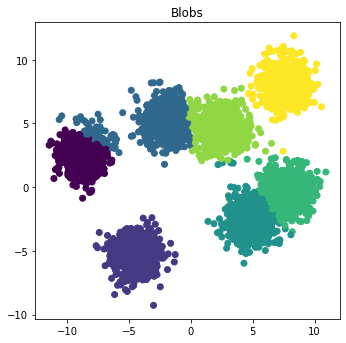

In [88]:
labels = predictions.select('prediction').toPandas()['prediction']

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("Blobs")

In [89]:
from metrics import ChIndex

In [90]:
predictions.show(3)

+----------+----------+--------------------+----------+
|         A|         B|            features|prediction|
+----------+----------+--------------------+----------+
| -8.592651| 2.3468647|[-8.5926513671875...|         0|
| 5.6484857| -2.408299|[5.64848566055297...|         3|
|-4.2641635|-5.4313807|[-4.2641634941101...|         1|
+----------+----------+--------------------+----------+
only showing top 3 rows



In [101]:
from metrics import Measure
from metrics.utils import *
from pyspark.sql.functions import mean as _mean, col

class ChIndex(Measure):
    '''
    Note: doesn't found info about ch-index
    '''

    def __init__(self, centroids=None, cluster_sizes=None, x_center=0, numerator=None,
                 denominator=None, diameter=0):
        self.centroids = none_check(centroids)
        self.cluster_sizes = none_check(cluster_sizes)
        self.x_center = x_center
        self.numerator = none_check(numerator)
        self.denominator = none_check(denominator)
        self.diameter = diameter

    def find(self, data, spark_context, labels, n_clusters):
        print()
        sql = SQLContext(spark_context)
        rows, columns = spark_shape(data)
        
        # "drop" features and labels
        mean_columns = map(lambda x: _mean(col(x)).alias('mean'), data.columns)
#         print(mean_columns.collect())
        df_stats = data.select(*mean_columns).collect()
        try:
            print(df_stats.show(10))
        except:
            print(df_stats)
#         print(df_stats)
        df = spark_join(data, labels, 'labels', sql)
        try:
            print(df.show(10))
        except:
            print(df)
        self.x_center = np.array(df_stats[0])
        self.centroids = cluster_centroid(df, spark_context, n_clusters)
        self.diameter = find_diameter(df, spark_context)
        ch = float(rows - n_clusters) / float(n_clusters - 1)

        self.cluster_sizes = count_cluster_sizes(labels, n_clusters)
        self.numerator = [0 for _ in range(n_clusters)]
        for i in range(0, n_clusters):
             self.numerator[i] = self.cluster_sizes[i] * euclidian_dist(self.centroids[i], self.x_center)
        denominator_sum = spark_context.accumulator(0)

        def f(row, acc, centroid):
            acc += euclidian_dist(row[:-2], centroid[row[-2]])

        df.foreach(lambda row: f(row, denominator_sum, self.centroids))
        self.denominator = denominator_sum.value
        ch *= np.sum(self.numerator)
        ch /= self.denominator
        return -ch

    def update(self, data, spark_context, n_clusters, labels, k, l, id): # doesn't work
        rows, columns = spark_shape(data)
        sql = SQLContext(spark_context)
        df = spark_join(data, labels, 'labels', sql)
        delta = 10 ** (-math.log(rows, 10) - 1)
        point = df.filter(df.row_idx.isin(id))
        prev_centroids = np.copy(self.centroids)
        self.cluster_sizes = count_cluster_sizes(labels, n_clusters)
        self.centroids = update_centroids(self.centroids, np.copy(self.cluster_sizes), point, k, l)
        ch = float(len(labels) - n_clusters) / float(n_clusters - 1)
        self.numerator[k] = self.cluster_sizes[k] * euclidian_dist(self.centroids[k], self.x_center)
        self.numerator[l] = self.cluster_sizes[l] * euclidian_dist(self.centroids[l], self.x_center)
        denom = spark_context.accumulator(0)

        def f(k, l, prev_centroids, centroids, delta, diameter, row, denom):
            if (row[-2] == k and euclidian_dist(prev_centroids[k], centroids[k]) > delta * diameter
               or row[-2] == l and euclidian_dist(prev_centroids[l], centroids[l]) > delta * diameter):
                denom += (euclidian_dist(row[:-2], centroids[row[-2]])
                                     - euclidian_dist(row[:-2], prev_centroids[row[-2]]))

        df.foreach(lambda row: f(k, l, prev_centroids, self.centroids, delta, self.diameter, row, denom))
        self.denominator += denom.value
        ch *= sum(self.numerator)
        ch /= self.denominator
        return -ch




ch_index = ChIndex()
measure_value = ch_index.find(predictions.drop('features', 'prediction'), sc, labels, n_clusters)


[Row(mean=1.1093985631655903, mean=1.7660897606964223)]
+-----------+------------+------+-------+
|          A|           B|labels|row_idx|
+-----------+------------+------+-------+
|  -8.592651|   2.3468647|     0|      1|
|  5.6484857|   -2.408299|     3|      2|
| -4.2641635|  -5.4313807|     1|      3|
|   8.433325|-0.022890316|     4|      4|
|  -9.574864|   2.5845852|     0|      5|
|    5.39665|  -3.1193328|     3|      6|
| -7.9665375|    2.909359|     0|      7|
| -2.9741478|   5.1243925|     2|      8|
|  -5.355328|     -5.6686|     1|      9|
|-0.54771763|   4.5131726|     2|     10|
+-----------+------------+------+-------+
only showing top 10 rows

None


In [102]:
measure_value

-4371.626305943682

In [93]:
predictions.show(10)

+-----------+------------+--------------------+----------+
|          A|           B|            features|prediction|
+-----------+------------+--------------------+----------+
|  -8.592651|   2.3468647|[-8.5926513671875...|         0|
|  5.6484857|   -2.408299|[5.64848566055297...|         3|
| -4.2641635|  -5.4313807|[-4.2641634941101...|         1|
|   8.433325|-0.022890316|[8.43332481384277...|         4|
|  -9.574864|   2.5845852|[-9.5748643875122...|         0|
|    5.39665|  -3.1193328|[5.39664983749389...|         3|
| -7.9665375|    2.909359|[-7.9665374755859...|         0|
| -2.9741478|   5.1243925|[-2.9741477966308...|         2|
|  -5.355328|     -5.6686|[-5.3553280830383...|         1|
|-0.54771763|   4.5131726|[-0.5477176308631...|         2|
+-----------+------------+--------------------+----------+
only showing top 10 rows



In [29]:
predictions.printSchema()

root
 |-- A: float (nullable = true)
 |-- B: float (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [39]:
predictions.groupby('prediction').count().toPandas()

,prediction,count
0,1,714
1,6,733
2,3,715
3,5,696
4,4,715
5,2,736
6,0,691


In [41]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         6|
|         3|
|         5|
|         4|
|         2|
|         0|
+----------+



In [42]:


time.time()

1621948365.9184213

In [54]:
import numpy as np
import math

from pyspark.sql.functions import mean as _mean, col

from metrics.spark_custom import spark_join
from metrics.utils import *
from metrics import Measure
from pyspark import SparkContext, SQLContext


class ChIndex(Measure):
    '''
    Note: doesn't found info about ch-index
    '''

    def __init__(self, centroids=None, cluster_sizes=None, x_center=0, numerator=None,
                 denominator=None, diameter=0):
        self.centroids = none_check(centroids)
        self.cluster_sizes = none_check(cluster_sizes)
        self.x_center = x_center
        self.numerator = none_check(numerator)
        self.denominator = none_check(denominator)
        self.diameter = diameter

    def find(self, data, spark_context, labels, n_clusters):
        sql = SQLContext(spark_context)
        rows, columns = spark_shape(data)
        mean_columns = map(lambda x: _mean(col(x)).alias('mean'), data.columns)
        df_stats = data.select(
            *mean_columns
        ).collect()
        df = spark_join(data, labels, 'labels', sql)
        self.x_center = np.array(df_stats[0])
        self.centroids = cluster_centroid(df, spark_context, n_clusters)
        self.diameter = find_diameter(df, spark_context)
        ch = float(rows - n_clusters) / float(n_clusters - 1)

        self.cluster_sizes = count_cluster_sizes(labels, n_clusters)
        self.numerator = [0 for _ in range(n_clusters)]
        for i in range(0, n_clusters):
             self.numerator[i] = self.cluster_sizes[i] * euclidian_dist(self.centroids[i], self.x_center)
        denominator_sum = spark_context.accumulator(0)

        def f(row, acc, centroid):
            acc += euclidian_dist(row[:-2], centroid[row[-2]])

        df.foreach(lambda row: f(row, denominator_sum, self.centroids))
        self.denominator = denominator_sum.value
        ch *= np.sum(self.numerator)
        ch /= self.denominator
        return -ch

    def update(self, data, spark_context, n_clusters, labels, k, l, id): # doesn't work
        rows, columns = spark_shape(data)
        sql = SQLContext(spark_context)
        df = spark_join(data, labels, 'labels', sql)
        delta = 10 ** (-math.log(rows, 10) - 1)
        point = df.filter(df.row_idx.isin(id))
        prev_centroids = np.copy(self.centroids)
        self.cluster_sizes = count_cluster_sizes(labels, n_clusters)
        self.centroids = update_centroids(self.centroids, np.copy(self.cluster_sizes), point, k, l)
        ch = float(len(labels) - n_clusters) / float(n_clusters - 1)
        self.numerator[k] = self.cluster_sizes[k] * euclidian_dist(self.centroids[k], self.x_center)
        self.numerator[l] = self.cluster_sizes[l] * euclidian_dist(self.centroids[l], self.x_center)
        denom = spark_context.accumulator(0)

        def f(k, l, prev_centroids, centroids, delta, diameter, row, denom):
            if (row[-2] == k and euclidian_dist(prev_centroids[k], centroids[k]) > delta * diameter
               or row[-2] == l and euclidian_dist(prev_centroids[l], centroids[l]) > delta * diameter):
                denom += (euclidian_dist(row[:-2], centroids[row[-2]])
                                     - euclidian_dist(row[:-2], prev_centroids[row[-2]]))

        df.foreach(lambda row: f(k, l, prev_centroids, self.centroids, delta, self.diameter, row, denom))
        self.denominator += denom.value
        ch *= sum(self.numerator)
        ch /= self.denominator
        return -ch

ch_index = ChIndex()
measure_value = ch_index.find(predictions.drop('features', 'prediction'), sc, labels, n_clusters)

KeyboardInterrupt: 

In [62]:
df = pd.DataFrame({'A': [15, 5, 20, 40], 'B': [1, 3, 5, 7], 'labels':[0, 0, 1, 1]})


df = pandas_to_spark(df)

In [81]:
sums = df.groupBy().sum().collect()

IllegalArgumentException: requirement failed: The number of columns doesn't match.
Old column names (3): sum(A), sum(B), sum(labels)
New column names (0): 

In [75]:
import pyspark.sql.functions as func

df.groupBy("labels").agg(func.max("A"), func.sum("B")).collect()

[Row(labels=0, max(A)=15, sum(B)=4), Row(labels=1, max(A)=40, sum(B)=12)]

In [103]:
sc.parallelize(range(10000))

PythonRDD[11876] at RDD at PythonRDD.scala:53

In [105]:
predictions.show(5)

+----------+------------+--------------------+----------+
|         A|           B|            features|prediction|
+----------+------------+--------------------+----------+
| -8.592651|   2.3468647|[-8.5926513671875...|         0|
| 5.6484857|   -2.408299|[5.64848566055297...|         3|
|-4.2641635|  -5.4313807|[-4.2641634941101...|         1|
|  8.433325|-0.022890316|[8.43332481384277...|         4|
| -9.574864|   2.5845852|[-9.5748643875122...|         0|
+----------+------------+--------------------+----------+
only showing top 5 rows

